In [1]:
import pandas as pd

### Reading in transformed data from 01

In [2]:
rides = pd.read_parquet("../data/transformed/validated_rides_2022_01.parquet")
#/Users/keshansharp/real_world_ml/taxi_demand_predictor/data/transformed/validated_rides_2022_01.parquet
rides.head(10)

,pickup_datetime,pickup_location_id
0,2022-01-01 00:35:40,142
1,2022-01-01 00:33:43,236
2,2022-01-01 00:53:21,166
3,2022-01-01 00:25:21,114
4,2022-01-01 00:36:48,68
5,2022-01-01 00:40:15,138
6,2022-01-01 00:20:50,233
7,2022-01-01 00:13:04,238
8,2022-01-01 00:30:02,166
9,2022-01-01 00:48:52,236


Creating a new column pickup hour 


- .dt: This is an accessor object for datetime-like properties of the Series. It allows you to use various datetime-related attributes and methods on the pickup_datetime column.

- .floor("H"): The floor method is used to round down the datetime values to the nearest specified frequency. In this case, "H" specifies that you want to round down to the nearest hour. This means that for each datetime value in the pickup_datetime column, the minutes and seconds will be set to zero, effectively giving you the start of the hour for each datetime.

In [3]:
rides["pickup_hour"] = rides["pickup_datetime"].dt.floor("H")

/var/folders/rz/v2_v6xwd24v6fdtmrs313wmr0000gn/T/ipykernel_45545/318692627.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rides["pickup_hour"] = rides["pickup_datetime"].dt.floor("H")


Groupby to aggregate the pickup hour and location id

- .size(): This function calculates the size of each group. In this context, it counts the number of rides for each unique combination of pickup_hour and pickup_location_id. The result is a Series with a multi-index (composed of pickup_hour and pickup_location_id) and the count of rides as values.

- .reset_index(): This converts the multi-index Series back into a DataFrame. The pickup_hour and pickup_location_id become regular columns again, and the counts of rides become another column. By default, the column with the counts will be unnamed and indexed as 0.

In [4]:
agg_rides = rides.groupby(["pickup_hour", "pickup_location_id"]).size()
agg_rides

pickup_hour          pickup_location_id
2022-01-01 00:00:00  4                     11
                     7                      6
                     10                     1
                     12                     2
                     13                    12
                                           ..
2022-01-31 23:00:00  261                    4
                     262                    8
                     263                   26
                     264                   24
                     265                    4
Length: 66868, dtype: int64

In [5]:
agg_rides = agg_rides.reset_index()
agg_rides

,pickup_hour,pickup_location_id,0
0,2022-01-01 00:00:00,4,11
1,2022-01-01 00:00:00,7,6
2,2022-01-01 00:00:00,10,1
3,2022-01-01 00:00:00,12,2
4,2022-01-01 00:00:00,13,12
...,...,...,...
66863,2022-01-31 23:00:00,261,4
66864,2022-01-31 23:00:00,262,8
66865,2022-01-31 23:00:00,263,26
66866,2022-01-31 23:00:00,264,24


In [6]:
agg_rides.rename(columns={0:"rides"}, inplace=True)
agg_rides

,pickup_hour,pickup_location_id,rides
0,2022-01-01 00:00:00,4,11
1,2022-01-01 00:00:00,7,6
2,2022-01-01 00:00:00,10,1
3,2022-01-01 00:00:00,12,2
4,2022-01-01 00:00:00,13,12
...,...,...,...
66863,2022-01-31 23:00:00,261,4
66864,2022-01-31 23:00:00,262,8
66865,2022-01-31 23:00:00,263,26
66866,2022-01-31 23:00:00,264,24


There is no time where there is 0 pickups. However for other datasets this could be possible, therefore we will add a function which deals with this incase future data does have this to make sure we have a complete time-series and no missing values.

In [7]:
agg_rides["rides"].describe()

count    66868.000000
mean        36.846907
std         59.993033
min          1.000000
25%          1.000000
50%          7.000000
75%         48.000000
max        601.000000
Name: rides, dtype: float64

### Create a function which will make sure the number of rides matches up with pickup hour and pick up location id

The code defines a function add_missing_slots that ensures all hourly time slots have entries for each pickup location in the agg_rides DataFrame. It fills in any missing hourly time slots with zeros for the ride counts. 

In [8]:
agg_rides

,pickup_hour,pickup_location_id,rides
0,2022-01-01 00:00:00,4,11
1,2022-01-01 00:00:00,7,6
2,2022-01-01 00:00:00,10,1
3,2022-01-01 00:00:00,12,2
4,2022-01-01 00:00:00,13,12
...,...,...,...
66863,2022-01-31 23:00:00,261,4
66864,2022-01-31 23:00:00,262,8
66865,2022-01-31 23:00:00,263,26
66866,2022-01-31 23:00:00,264,24


In [9]:
from tqdm import tqdm   

In [10]:
def add_missing_slots(agg_rides: pd.DataFrame) -> pd.DataFrame:
    
    # Get an array of unqique pickup location ids
    location_ids = agg_rides['pickup_location_id'].unique()

    # Create a dataframe containing all hourly timestamps from the earliest to the latest
    full_range = pd.date_range(
        agg_rides['pickup_hour'].min(), agg_rides['pickup_hour'].max(), freq='H')
    
    # Initialise an empty datframe 
    output = pd.DataFrame()
    
    # Iterate through the unique location id's array
    for location_id in tqdm(location_ids):

        # Keep only rides for this location id
            # agg_rides is the original DataFrame containing ride data.
            # agg_rides.pickup_location_id == location_id creates a boolean Series, where each element is True if the corresponding row in the pickup_location_id column matches the current location_id being processed in the loop, and False otherwise.
            # agg_rides.loc[...] uses the .loc indexer to select rows where the condition inside the brackets is True. This effectively filters the DataFrame to include only rows where pickup_location_id equals location_id.
            # Only the pickup_hour and rides columns are selected from the filtered rows.
        agg_rides_i = agg_rides.loc[ agg_rides.pickup_location_id == location_id, ['pickup_hour', 'rides'] ]
        
        # Set Index to pickup hour
        
        # Quick way to add missing dates with 0 in a Series 
        # Taken from stackoverflow: https://stackoverflow.com/a/19324591

        # The pickup_hour column is set as the index for agg_rides_i.
        # The index is converted to a DatetimeIndex to facilitate time-based operations.
        agg_rides_i.set_index('pickup_hour', inplace=True)
        agg_rides_i.index = pd.DatetimeIndex(agg_rides_i.index)

        # The agg_rides_i DataFrame is reindexed to include all hours in full_range. Missing hours are filled with zeroes.
        agg_rides_i = agg_rides_i.reindex(full_range, fill_value=0)

        # Add back location id column back in
        # The pickup_location_id column is added back to agg_rides_i, with the value set to the current location_id.
        agg_rides_i['pickup_location_id'] = location_id

        output = pd.concat([output, agg_rides_i])

    # Move the purchase day from the index to a dataframe column
    # The index is reset to convert the pickup_hour index back to a column.
    # The column previously named index is renamed to pickup_hour.
    output = output.reset_index().rename(columns={'index': 'pickup_hour'})

    return output

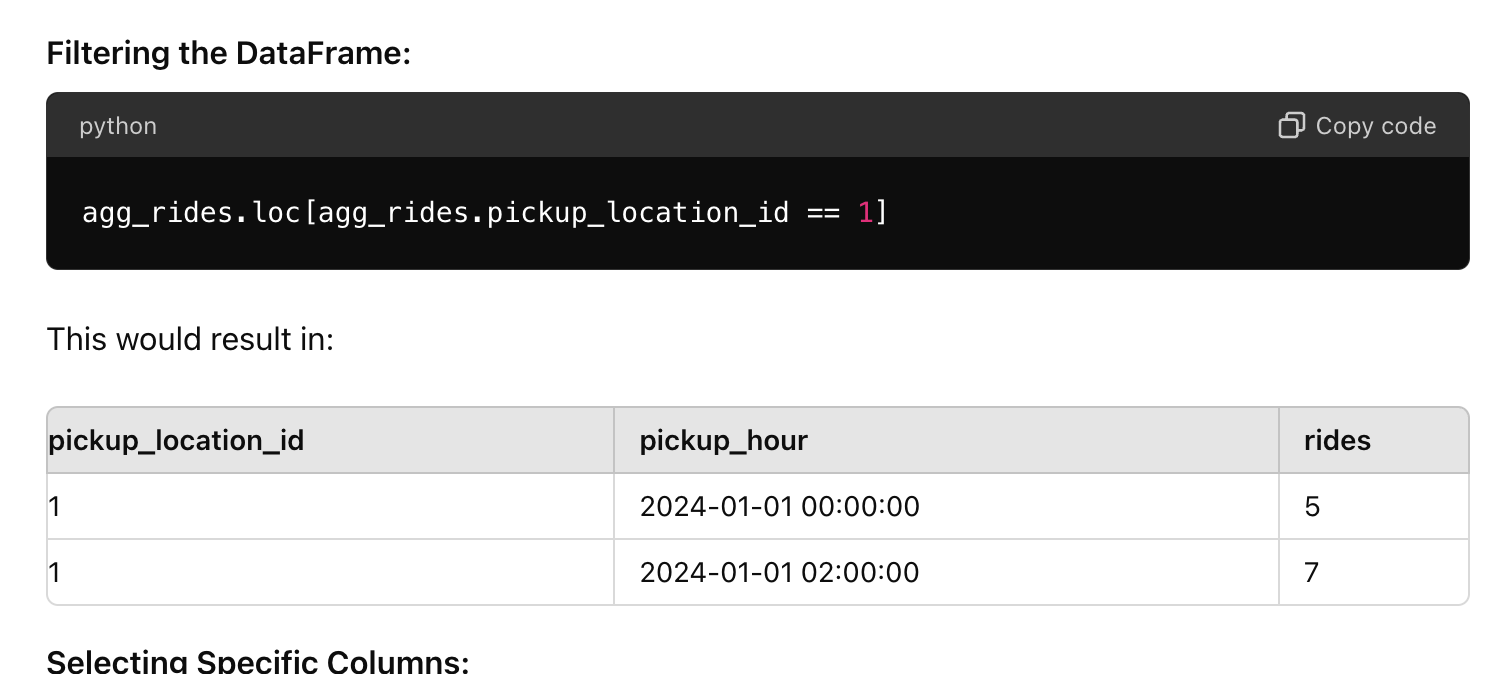
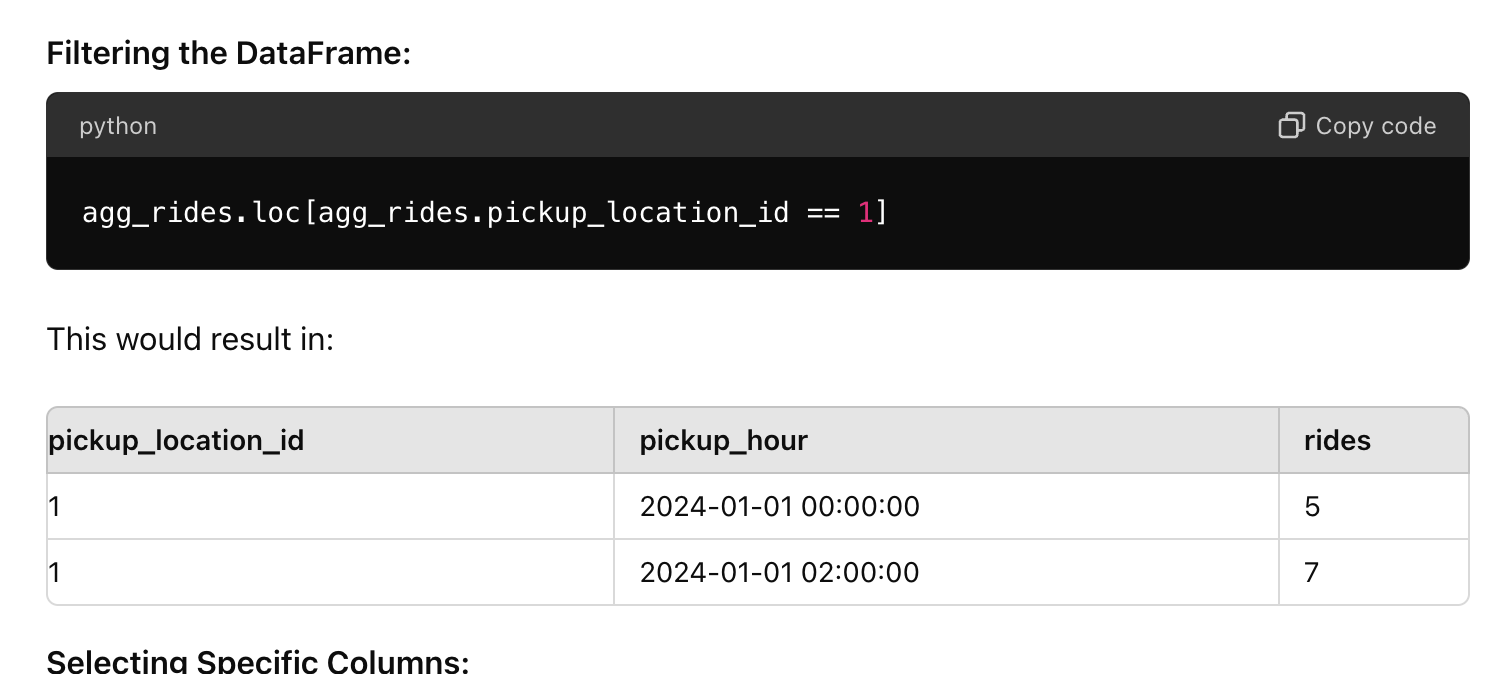

### Now we have no of rides at pickup location id each hour

In [11]:
agg_rides_all_slots = add_missing_slots(agg_rides)
agg_rides_all_slots.head(10)

/var/folders/rz/v2_v6xwd24v6fdtmrs313wmr0000gn/T/ipykernel_45545/2112624274.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(
100%|██████████| 257/257 [00:00<00:00, 1596.79it/s]


,pickup_hour,rides,pickup_location_id
0,2022-01-01 00:00:00,11,4
1,2022-01-01 01:00:00,15,4
2,2022-01-01 02:00:00,26,4
3,2022-01-01 03:00:00,8,4
4,2022-01-01 04:00:00,9,4
5,2022-01-01 05:00:00,7,4
6,2022-01-01 06:00:00,3,4
7,2022-01-01 07:00:00,1,4
8,2022-01-01 08:00:00,0,4
9,2022-01-01 09:00:00,3,4


### Plot time-series data 

In [12]:
from typing import Optional, List
import plotly.express as px

def plot_rides(
    rides: pd.DataFrame,
    locations: Optional[List[int]] = None
    ):
    """
    Plot time-series data
    """
    rides_to_plot = rides[rides.pickup_location_id.isin(locations)] if locations else rides

    fig = px.line(
        rides_to_plot,
        x="pickup_hour",
        y="rides",
        color='pickup_location_id',
        template='none',
    )

    fig.show()

### Let's look at location 43 only

In [13]:
plot_rides(agg_rides_all_slots, locations=[43])

In [14]:
agg_rides_all_slots.to_parquet('../data/transformed/ts_data_2022_01.parquet')